# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install scikit-learn matplotlib seaborn

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

/home/joey/sp25-dl/project2/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 19:57:17.691893: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 19:57:17.702316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745279837.713990  532736 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745279837.717612  532736 cuda_blas.cc:1407

## Load Tokenizer and Preprocess Data

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Make train and eval split

In [5]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=1280, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

print("Number of train samples:", len(train_dataset))
print("Number of eval samples:", len(eval_dataset))

Number of train samples: 118720
Number of eval samples: 1280


## Training Setup

In [6]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [7]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

## Training

In [10]:
output_dir = "final_submission_model" # base directory for all DSE runs


In [ ]:
# 1. load Base Model
print("Loading base model...")
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)


# Configure LoRA
peft_config = LoraConfig(
    r=6,  # LoRA rank
    lora_alpha=6,  # Alpha parameter for scaling
    lora_dropout=0.1, # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"], # Apply LoRA to these layers
    bias="none",  # Don't train bias parameters
    task_type="SEQ_CLS",
)

peft_model = get_peft_model(model, peft_config)

print("PEFT Model Configured:")
peft_model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy="steps",
    logging_steps=100,
    learning_rate=1e-5,
    max_steps=2000,
    num_train_epochs=1,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64, # or 128
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant': True},
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)

# 6. train the model
print("Starting training...")
train_result = trainer.train()
print("Training finished.")
trainer.save_model()

# 7. evaluate the model after training
print("Evaluating model on evaluation set...")
eval_metrics, _ = evaluate_model(
    peft_model,
    eval_dataset,
    labelled=True,
    batch_size=training_args.per_device_eval_batch_size,
    data_collator=data_collator
)
final_accuracy = eval_metrics['accuracy']

print(f"Accuracy: {final_accuracy:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading base model...
PEFT Model Configured:
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.386100,1.383531,0.359375
200,1.378500,1.372553,0.559375
300,1.370500,1.362064,0.668750
400,1.358000,1.348194,0.637500
500,1.339100,1.326620,0.707031
600,1.308500,1.288152,0.837500
700,1.252700,1.222496,0.837500
800,1.167300,1.099002,0.865625
900,1.010900,0.888320,0.871875
1000,0.780100,0.639427,0.875781


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [01:48<00:00,  5.45s/it]

Evaluation Metric: {'accuracy': 0.8859375}
Accuracy: 0.8859


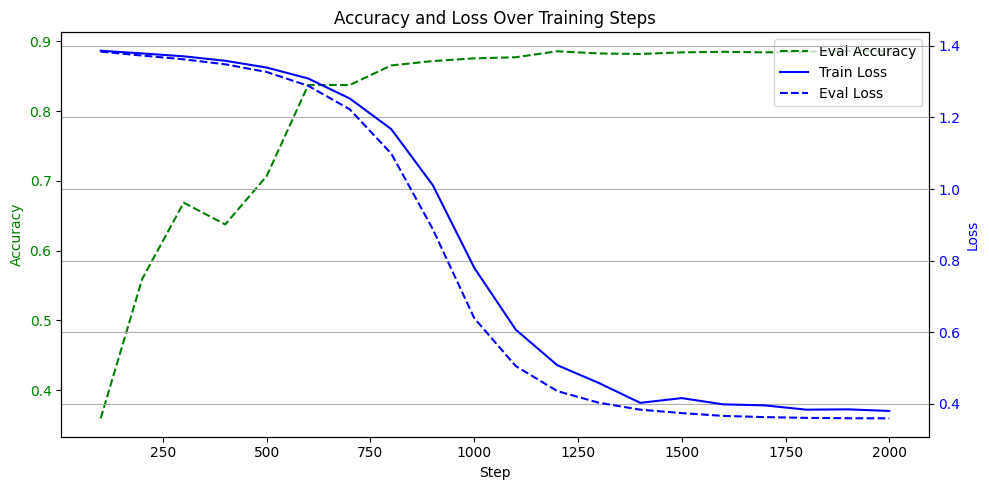

In [22]:
import matplotlib.pyplot as plt

# Extract log data
log_history = trainer.state.log_history

train_loss = [(e['step'], e['loss']) for e in log_history if 'loss' in e]
eval_loss = [(e['step'], e['eval_loss']) for e in log_history if 'eval_loss' in e]
train_acc = [(e['step'], e['accuracy']) for e in log_history if 'accuracy' in e]
eval_acc = [(e['step'], e['eval_accuracy']) for e in log_history if 'eval_accuracy' in e]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot accuracy on left y-axis
if train_acc:
    steps, values = zip(*train_acc)
    ax1.plot(steps, values, label='Train Accuracy', color='green')
if eval_acc:
    steps, values = zip(*eval_acc)
    ax1.plot(steps, values, label='Eval Accuracy', color='green', linestyle='--')

ax1.set_xlabel('Step')
ax1.set_ylabel('Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a second y-axis for loss
ax2 = ax1.twinx()

if train_loss:
    steps, values = zip(*train_loss)
    ax2.plot(steps, values, label='Train Loss', color='blue')
if eval_loss:
    steps, values = zip(*eval_loss)
    ax2.plot(steps, values, label='Eval Loss', color='blue', linestyle='--')

ax2.set_ylabel('Loss', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Accuracy and Loss Over Training Steps')
plt.grid(True)
plt.tight_layout()
plt.savefig('hist.pdf')
plt.show()


100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


Evaluation Metric: {'accuracy': 0.8859375}


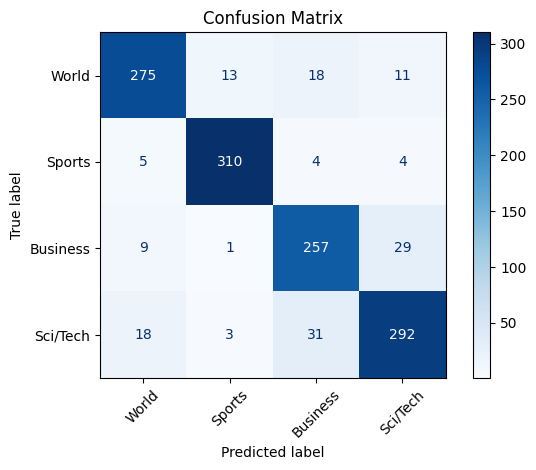

In [19]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

eval_metric, all_predictions = evaluate_model(peft_model, eval_dataset, labelled=True, batch_size=16, data_collator=data_collator)
true_labels = eval_dataset["labels"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, all_predictions.numpy())

label_names = ["World", "Sports", "Business", "Sci/Tech"]

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')
plt.show()

### Run Inference on unlabelled dataset

In [20]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:02<00:00, 3196.06 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [21]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]

Inference complete. Predictions saved to inference_output.csv
